In [1]:
!pip install prettytable


!pip install matplotlib


!pip install Pillow


# Install Tesseract di Jupyter Notebook menggunakan perintah pip
!pip install pytesseract


In [3]:
#Imports
import re
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract 



from skimage.filters import threshold_local
from PIL import Image
from pytesseract import Output
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe' 
from prettytable import PrettyTable

In [4]:
#Initialise Methods

#Resize image
def opencv_resize(image, ratio):
    width = int(image.shape[1] * ratio)
    height = int(image.shape[0] * ratio)
    dim = (width, height)
    return cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

#Display grey scale image
def plot_gray(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(image, cmap='Greys_r')

#Display RGB colour image
def plot_rgb(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

#We will use approxPolyDP for approximating more primitive contour shape consisting of as few points as possible
#Approximate the contour by a more primitive polygon shape
def approximate_contour(contour):
    peri = cv2.arcLength(contour, True)
    return cv2.approxPolyDP(contour, 0.032 * peri, True)

#Find 4 points of receipt
def get_receipt_contour(contours):    
    # loop over the contours
    for c in contours:
        approx = approximate_contour(c)
        # if our approximated contour has four points, we can assume it is receipt's rectangle
        if len(approx) == 4:
            return approx
        
#Convert 4 points into lines / rect      
def contour_to_rect(contour):
    pts = contour.reshape(4, 2)
    rect = np.zeros((4, 2), dtype = "float32")
    # top-left point has the smallest sum
    # bottom-right has the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    # compute the difference between the points:
    # the top-right will have the minumum difference 
    # the bottom-left will have the maximum difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect / resize_ratio

#Original receipt with wrapped perspective
def wrap_perspective(img, rect):
    # unpack rectangle points: top left, top right, bottom right, bottom left
    (tl, tr, br, bl) = rect
    # compute the width of the new image
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    # compute the height of the new image
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    # take the maximum of the width and height values to reach
    # our final dimensions
    maxWidth = max(int(widthA), int(widthB))
    maxHeight = max(int(heightA), int(heightB))
    # destination points which will be used to map the screen to a "scanned" view
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    # calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(rect, dst)
    # warp the perspective to grab the screen
    return cv2.warpPerspective(img, M, (maxWidth, maxHeight))

#Threshold image
def bw_scanner(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    T = threshold_local(gray, 21, offset = 5, method = "gaussian")
    return (gray > T).astype("uint8") * 255

def plot_gray(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(image, cmap='Greys_r')

def plot_rgb(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

def find_amounts(text):
    amounts = re.findall(r'\d+\.\d{2}\b', text)
    floats = [float(amount) for amount in amounts]
    unique = list(dict.fromkeys(floats))
    return unique


C:\Users\ikbar\AppData\Local\Temp\ipykernel_13848\1161705161.py:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img.thumbnail((800,800), Image.ANTIALIAS)


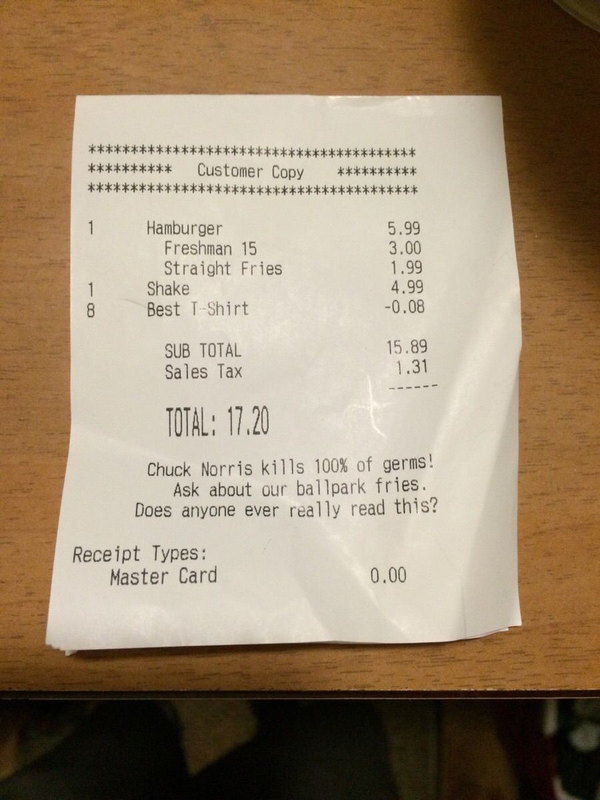

In [25]:
# Sample file out of the dataset
#dummy 01 : image on white background
#dummy 02 : image on gradient backgound
#dummy 03 : random reciept
#dummy 04 : random reciept
#Hits 02 and 09
file_name = 'struk6.png'

img = Image.open(file_name)
img.thumbnail((800,800), Image.ANTIALIAS)
img

In [26]:
image = cv2.imread(file_name)

#Downscale image.
#Finding receipt contour is more efficient on a small image
resize_ratio = 500 / image.shape[0]
original = image.copy()
image = opencv_resize(image, resize_ratio)

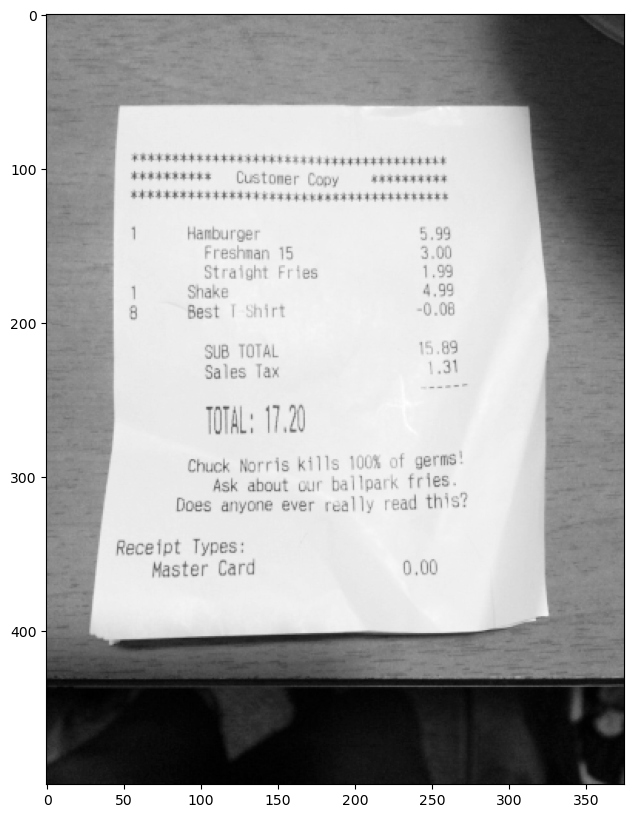

In [27]:
# Convert to grayscale for further processing
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plot_gray(gray)

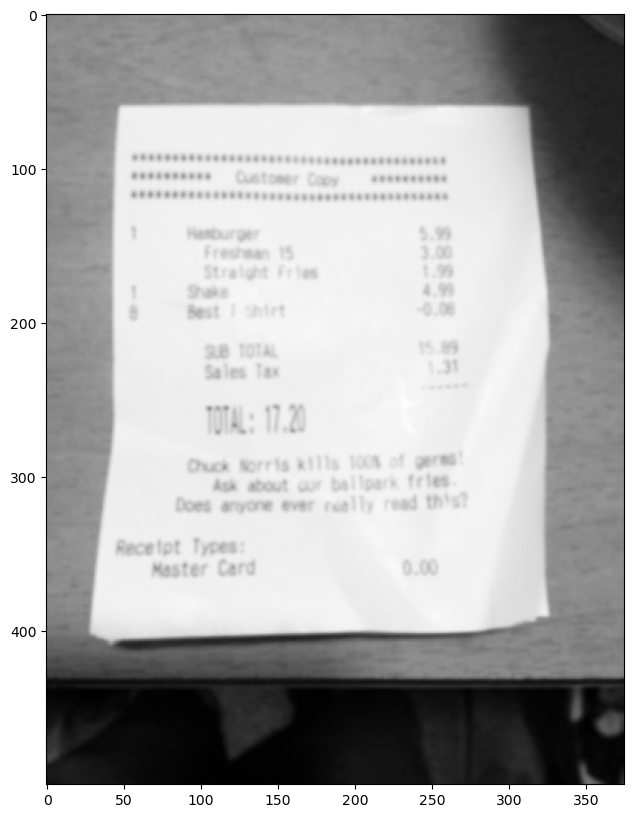

In [28]:
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
plot_gray(blurred)

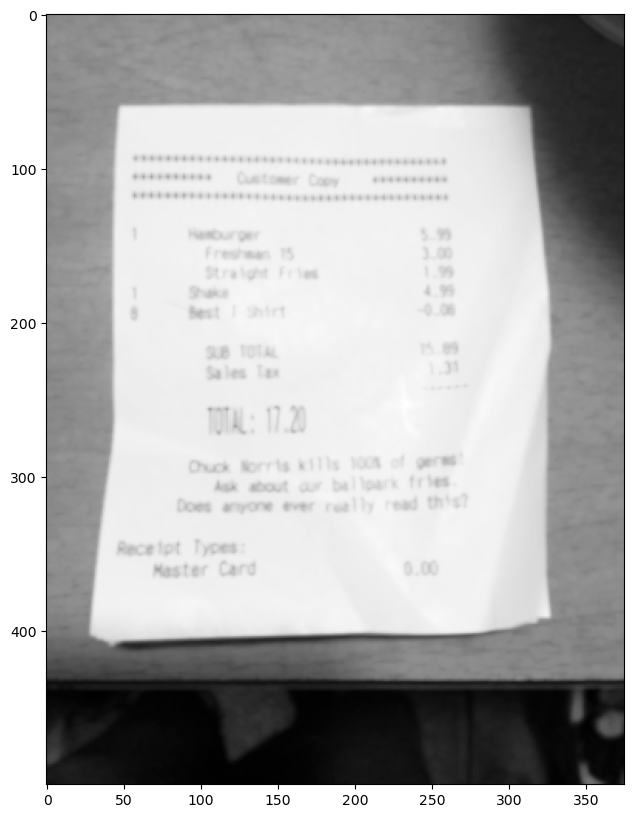

In [29]:
# Detect white regions
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
dilated = cv2.dilate(blurred, rectKernel)
plot_gray(dilated)

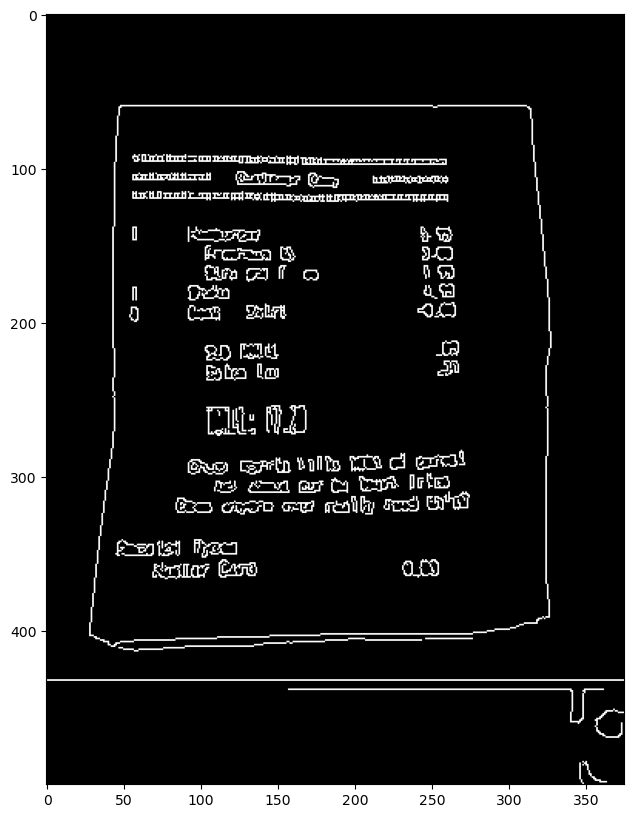

In [30]:
edged = cv2.Canny(dilated, 50, 125, apertureSize=3)
plot_gray(edged)

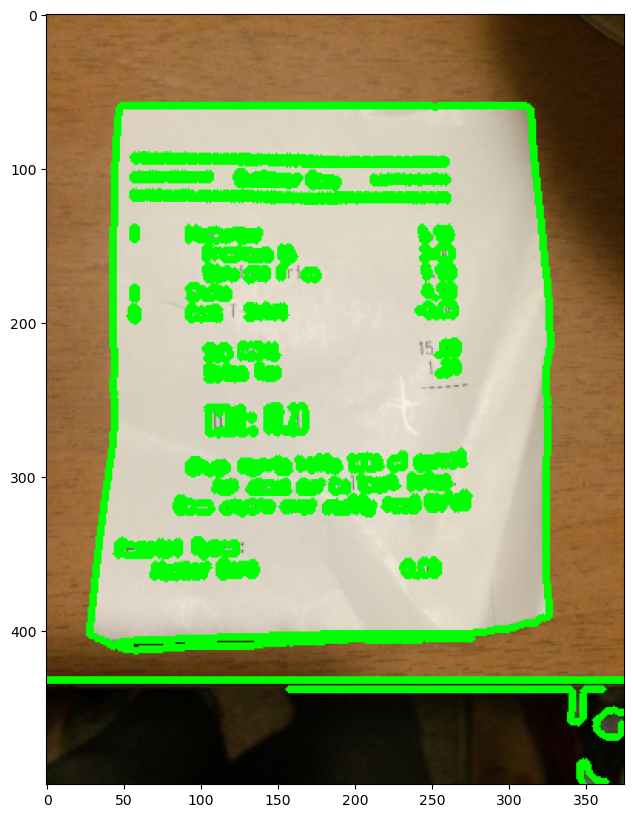

In [31]:
contours, hierarchy = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
image_with_contours = cv2.drawContours(image.copy(), contours, -1, (0,255,0), 3)
plot_rgb(image_with_contours)

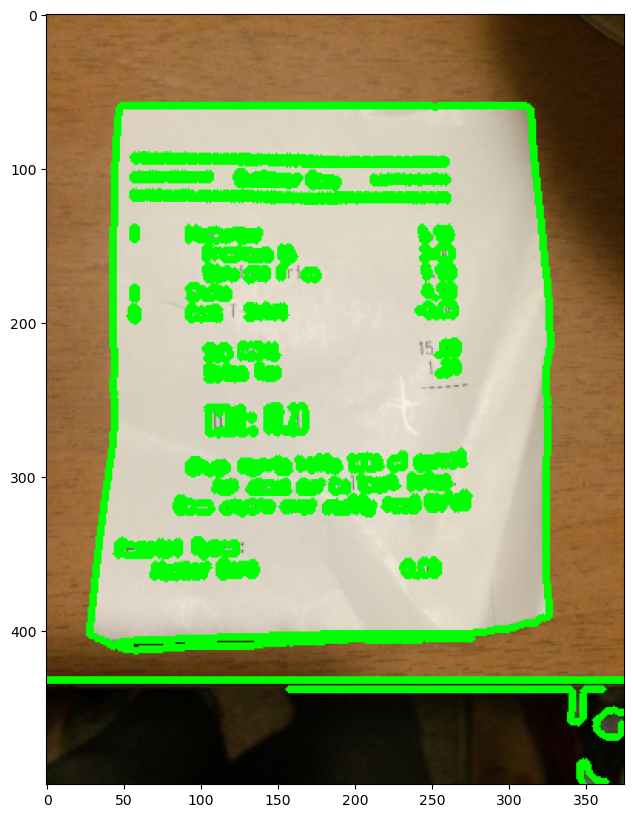

In [32]:
# Get 10 largest contours
largest_contours = sorted(contours, key = cv2.contourArea, reverse = True)[:1000]
image_with_largest_contours = cv2.drawContours(image.copy(), largest_contours, -1, (0,255,0), 3)
plot_rgb(image_with_largest_contours)

In [33]:
get_receipt_contour(largest_contours)

array([[[ 48,  59]],

       [[ 28, 403]],

       [[326, 391]],

       [[314,  61]]], dtype=int32)

In [34]:
receipt_contour = get_receipt_contour(largest_contours)

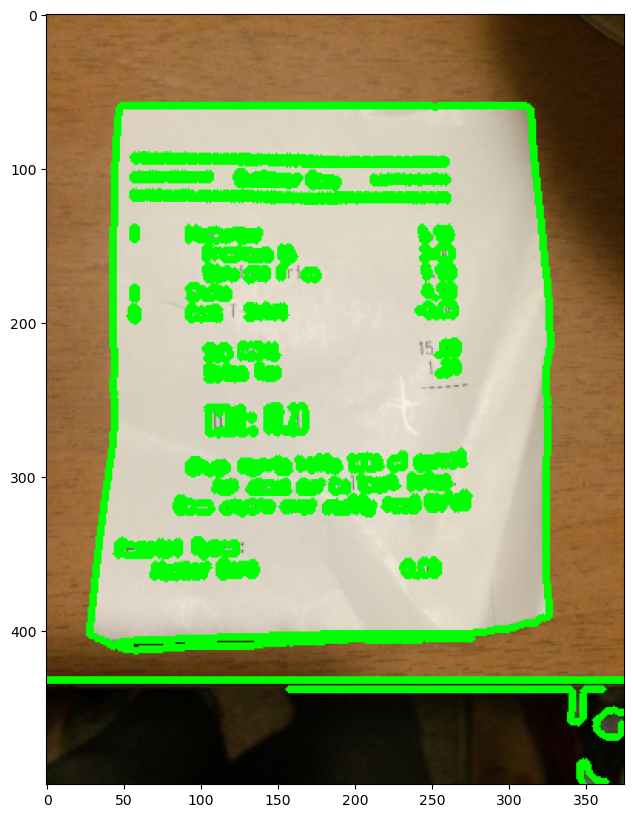

In [35]:
image_with_all_contours = cv2.drawContours(image.copy(), contours, -1, (0, 255, 0), 3)
plot_rgb(image_with_all_contours)


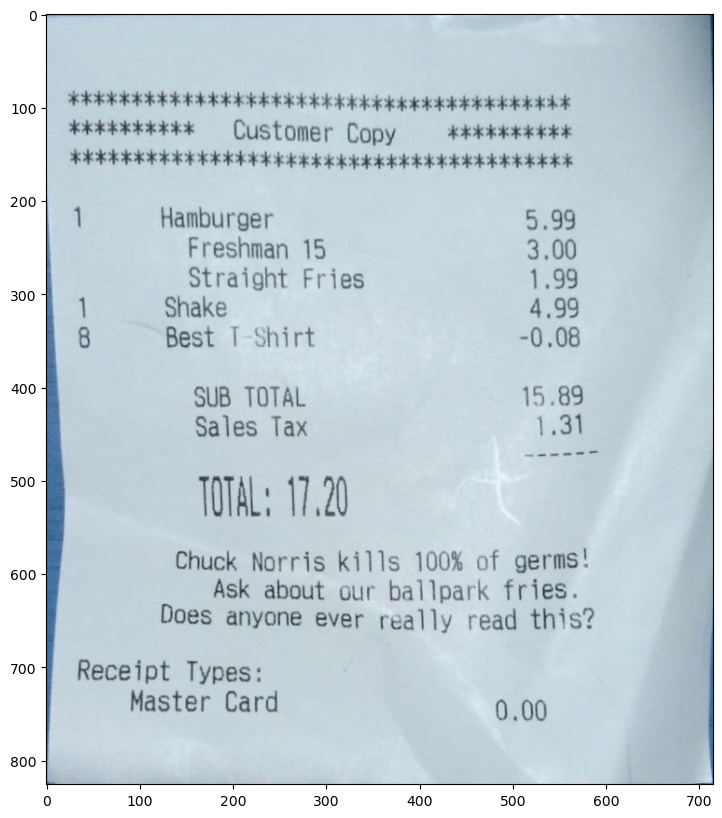

In [36]:
scanned = wrap_perspective(original.copy(), contour_to_rect(receipt_contour))
plt.figure(figsize=(16,10))
plt.imshow(scanned)

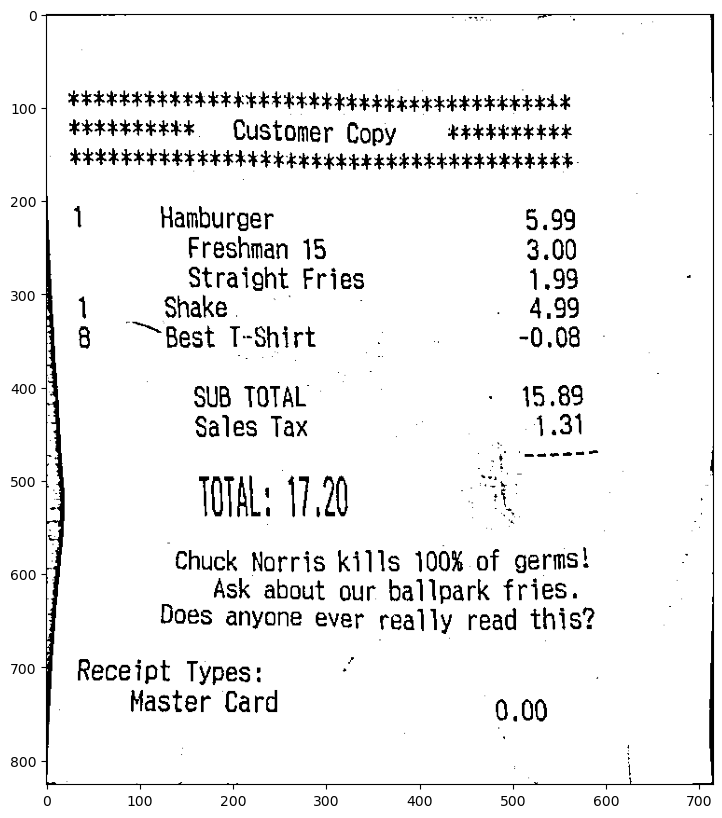

In [37]:
result = bw_scanner(scanned)
plot_gray(result)

C:\Users\ikbar\AppData\Local\Temp\ipykernel_13848\1179293760.py:4: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img.thumbnail((800,800), Image.ANTIALIAS)


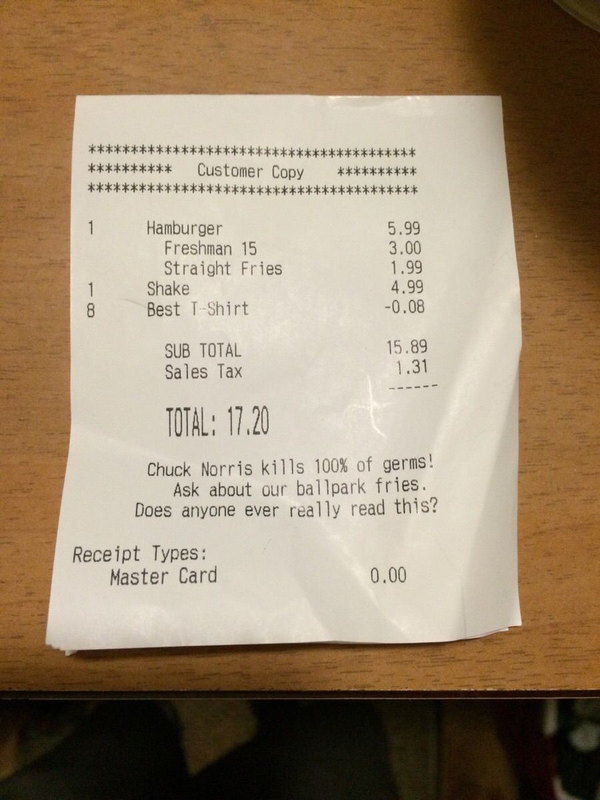

In [45]:
file_name = 'struk6.png'

img = Image.open(file_name)
img.thumbnail((800,800), Image.ANTIALIAS)
img

In [39]:
#Save image locally
output = Image.fromarray(result)
output.save('result.png')

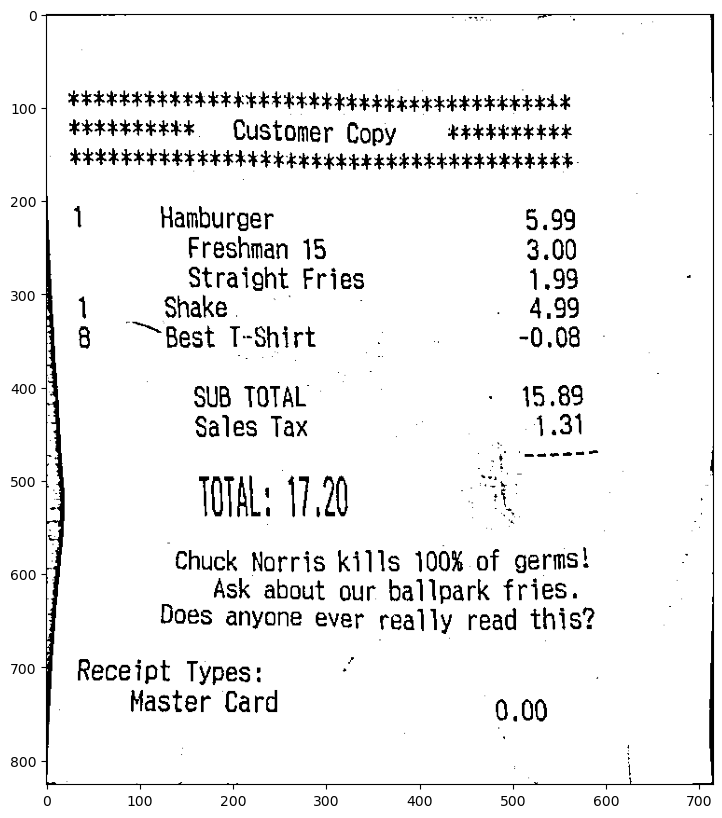

In [40]:
img
file_name = "result.png"
image = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE) 
plot_gray(image)

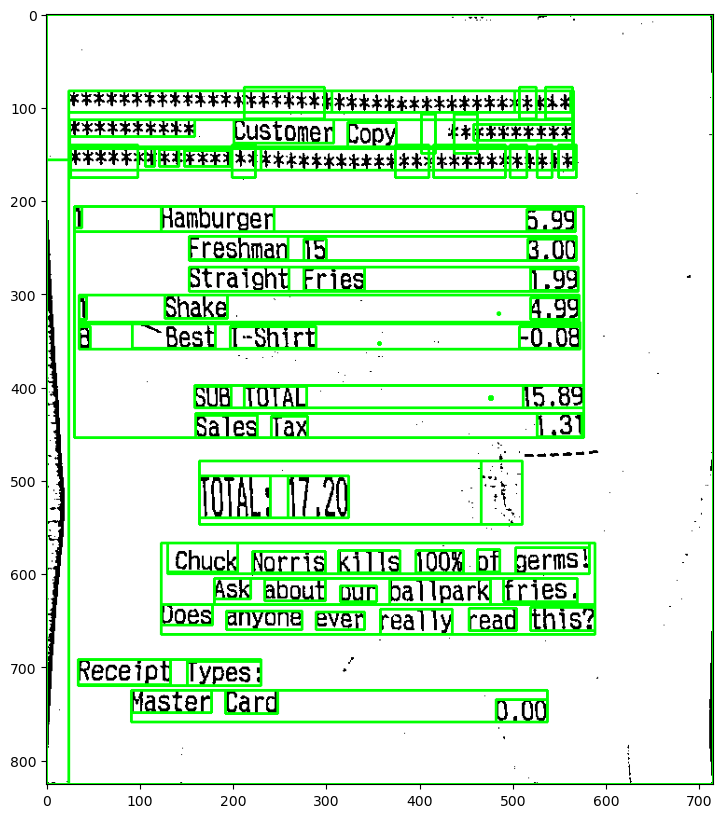

In [41]:
d = pytesseract.image_to_data(image, output_type=Output.DICT)

n_boxes = len(d['level'])
boxes = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)
for i in range(n_boxes):
    (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])    
    boxes = cv2.rectangle(boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
plot_rgb(boxes)

In [42]:
custom_config = r'--oem 3 --psm 6'
extracted_text = pytesseract.image_to_string(image, config=custom_config)
print(extracted_text)

PREt LUO O Li Solc ll roster trrrrrerrcrcec ese?
eeeeereEEE Customer Copy J3 OSE
peti oCotiiooolecoreteteerrattrrcrrrr: rs c4
1 Hamburger 5.99
Freshman 15 3.00
Straight Fries 1.99 .
1 _ Shake. ~ . 4,99
8 —~Best T-Shirt . -0.08
SUB TOTAL - 15.89
: Sales Tax _ 1.31
goo
: TIAL: 17.20 4
=: ‘Chuck Norris kills 100% of germs! :
Ask about our ballpark fries. |
Does anyone ever really read this?
Receipt Types: “ .
Master Card 0.00
fl



In [43]:
#Extract letters and numbers regex
regex_line = []
for line in extracted_text.splitlines():
    if re.search(r"[0-9]*\.[0-9]|[0-9]*\,[0-9]", line):
        regex_line.append(line)
print(regex_line)

['1 Hamburger 5.99', 'Freshman 15 3.00', 'Straight Fries 1.99 .', '1 _ Shake. ~ . 4,99', '8 —~Best T-Shirt . -0.08', 'SUB TOTAL - 15.89', ': Sales Tax _ 1.31', ': TIAL: 17.20 4', 'Master Card 0.00']


In [44]:
exclude = ["bank", "total", "promo", "vat", "change", "recyclable", "layanan", ":", "ppn"]

raw_items = []
found = False
for line in regex_line:
    invalid = False
    finished = False

    for (i, word) in enumerate(line.split()):
        # print(word)
        if any(c.isalpha() for c in word):
            if i > 1:
                invalid = True
            else:
                break

    for e in exclude:
        if e in line.lower():
            if found == True:
                finished = True

    if finished == True:
        break

    if invalid == False:
        raw_items.append(line)
        found = True

print(raw_items)

items = []
for item in raw_items:
    name = ""
    price = ""
    for (i, word) in enumerate(item.split()):
        number = ""
        valid = True
        if any(c.isalpha() for c in word):
            name = name + " " + word
        if word != "," and word != ".":
            for c in word:
                if c.isnumeric() or c == "." or c == ",":
                    number = number + c
                else:
                    valid = False
        else:
            valid = False
            
        
        if valid == True:
            price = number

    items.append((name.strip(), price))

t = PrettyTable(['Item', 'Cost'])
for (i, item) in enumerate(items):
    t.add_row([item[0], item[1]])

print(t)

['1 Hamburger 5.99', 'Freshman 15 3.00', 'Straight Fries 1.99 .', '8 —~Best T-Shirt . -0.08']
+----------------+------+
|      Item      | Cost |
+----------------+------+
|   Hamburger    | 5.99 |
|    Freshman    | 3.00 |
| Straight Fries | 1.99 |
| —~Best T-Shirt |  8   |
+----------------+------+
